In [67]:
import cvxpy as cp
import functools
import gymnasium
import importlib 
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm


import torch
from torch.autograd.functional import hessian
from torch.autograd.functional import jacobian

importlib.reload(gymnasium)

<module 'gymnasium' from '/Users/castrong/Desktop/Berkeley/Research/customized_gymnasium/gymnasium/__init__.py'>

In [68]:
# Try to use the gym ilqr environment
env = gymnasium.make("LQR-v0")
A = env.A 
B = env.B
Q = np.eye(2)
R = np.eye(2)

# Generate a nice reference trajectory 
def circle_x_ref(radius, freq, horizon):
    x_ref = np.zeros((horizon, 2))
    for i in range(horizon):
        x_ref[i, 0] = radius * np.cos(2 * np.pi * freq * i)
        x_ref[i, 1] = radius * np.sin(2 * np.pi * freq * i)

    return x_ref 

# # Roll out some random demonstrations
n_demonstrations = 20
horizon = 20
env.horizon = 20
x_reference = np.zeros((horizon+1, env.dim_state)) # circle_x_ref(10, 0.05, horizon) # 
# observations = np.zeros((n_demonstrations, horizon+1, env.dim_state))
# actions = np.zeros((n_demonstrations, horizon, env.dim_action))
# rewards = np.zeros((n_demonstrations, horizon))

# for i in range(n_demonstrations):
#     observation, info = env.reset(seed=42, horizon=horizon, x_reference=x_reference)
#     observations[i, 0, :] = observation
#     for t in range(horizon):
#         action = env.action_space.sample()
#         observation, reward, terminated, truncated, info = env.step(action)
#         # Store the observation, action, and reward
#         observations[i, t+1, :] = observation
#         actions[i, t, :] = action
#         rewards[i, t] = reward
#         assert not (truncated)     

In [69]:
# Implement an optimal controller
def random_controller(x_0, env):
    controls = np.zeros((env.horizon, env.dim_action))
    for i in range(env.horizon):
        controls[i, :] = env.action_space.sample()
    return np.array(controls, dtype=np.float32)

def controller(x_0, env, horizon=None):
    """
        A controller that will find  
    """
    if horizon is None:
        horizon = env.horizon

    x_ref = env.x_reference
    # Track your controls and states 
    controls = cp.Variable((horizon, env.dim_action))
    states = cp.Variable((horizon+1, env.dim_state))


    # constrain the first state to be x0
    constraints = [states[0, :] == x_0]

    # Start accumulating cost 
    cost = (x_0.T - x_ref[0, :]) @ env.Q @ (x_0 - x_ref[0, :])

    for i in range(horizon):
        constraints += [states[i+1, :] == env.A @ states[i, :] + env.B @ controls[i, :]]
        cost += cp.quad_form(states[i+1, :] - x_ref[i+1, :], env.Q) + cp.quad_form(controls[i, :],  env.R)


    objective = cp.Minimize(cost)
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status != cp.OPTIMAL:
        print("Controller did not converge")
        print(problem.status)
        print(problem.value)
        print(problem.solver_stats)
        assert False 

    return np.array(controls.value, dtype=np.float32)

def gather_demonstrations(x_reference, controller, n_demonstrations, env, Q, R, noise_level=0.0, open_loop=True):
    horizon = env.horizon
    observations = np.zeros((n_demonstrations, horizon+1, env.dim_state))
    actions = np.zeros((n_demonstrations, horizon, env.dim_action))
    rewards = np.zeros((n_demonstrations, horizon))

    for i in tqdm(range(n_demonstrations)):
        observation, info = env.reset(Q=Q, R=R, horizon=horizon, x_reference=x_reference)
        noise = noise_level * np.float32(np.random.randn(horizon, env.dim_action))
        controls = controller(observation, env, env.horizon) + noise

        observations[i, 0, :] = observation
        for t in range(horizon):
            if open_loop:
                action = controls[t, :]
            else:
                controls = controller(observation, env, env.horizon - t)
                # select the first control and add noise
                action = controls[0, :]
                action += noise_level * np.float32(np.random.randn(env.dim_action))
        
            observation, reward, terminated, truncated, info = env.step(action)
            # Store the observation, action, and reward
            observations[i, t+1, :] = observation
            actions[i, t, :] = action
            rewards[i, t] = reward
            assert not (terminated) 

    return observations, actions, rewards

def plot_demonstration(states, x_reference):
    plt.plot(states[:, 0], states[:, 1], 'o-', label="Expert")
    plt.plot(x_reference[:, 0], x_reference[:, 1], 'o-', label="Reference")
    plt.axis('equal')
    plt.legend()

# do a single rollout with this controller
# x_0, _ = env.reset(seed=42, Q=Q, R=R, horizon=horizon, x_reference=x_reference)

# states = np.zeros((horizon+1, env.dim_state))
# states[0, :] = x_0
# controls = controller(states[0, :], env)
# controls = np.array(controls, dtype=np.float32)

# for i in range(horizon):
#     control = controls[i, :]
#     observation, _, _, _, _ = env.step(control)
#     states[i+1, :] = observation

# plot_demonstration(states, x_reference)


In [70]:
# Generate demonstrations 
states, actions, rewards = gather_demonstrations(x_reference, controller, n_demonstrations, env, Q, R, noise_level=0.2, open_loop=False)
demonstrations = [(states[i, :, :], actions[i, :, :]) for i in range(n_demonstrations)]

100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


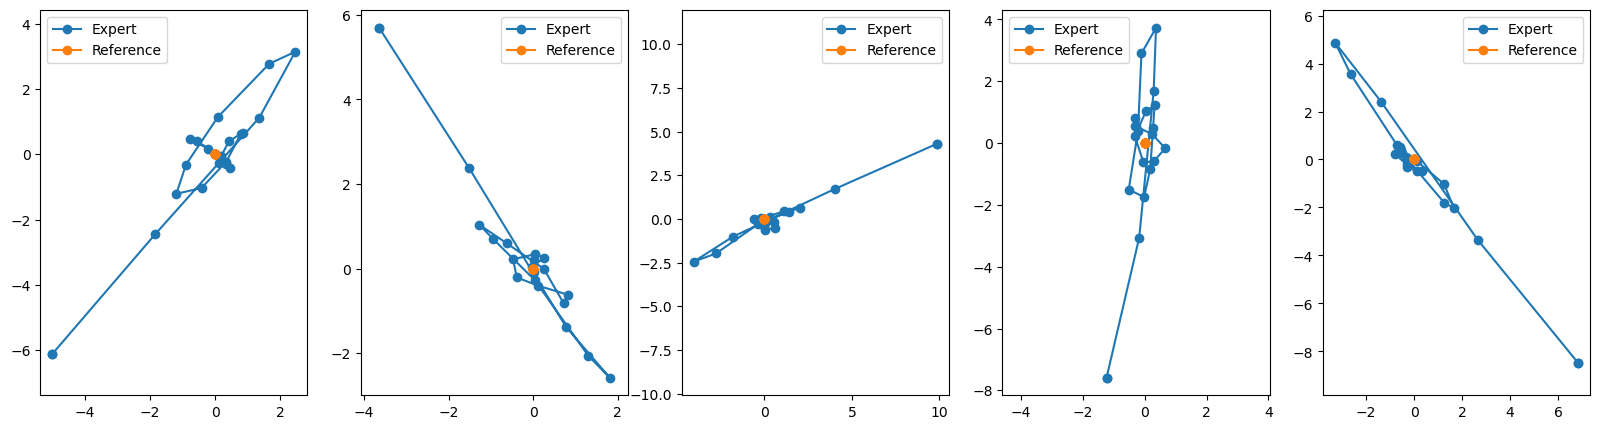

In [71]:
# Plot some 
n_to_plot = 5
# subplot with n_to_plot plots side by side
plt.subplots(1, n_to_plot, figsize=(20, 5))

for i in range(n_to_plot):
    plt.subplot(1, n_to_plot, i+1)
    plot_demonstration(states[i, :, :], x_reference)


In [72]:
# define feature functions
# example feature function 
def f(u, x_0, env_info, params):
    return u[0]**2

In [73]:
# define quadratic features on the control 
def quad_control_features(env):
    u_dim = env.dim_action
    feature_fcns = []
    indices = {}
    def quad_fcn(u, x_0, env_info, params, i, j):
        return torch.sum(u[:, i] * u[:, j])

    for i in range(u_dim):
        for j in range(i, u_dim):
            temp_f = functools.partial(quad_fcn, i=i, j=j)

            feature_fcns.append(temp_f)
            indices[(i, j)] = len(feature_fcns) - 1

    return feature_fcns, indices

# define quadratic features on the state 
def quad_state_features(env):
    A_torch = torch.tensor(env.A, dtype=torch.float32)
    B_torch = torch.tensor(env.B, dtype=torch.float32)
    feature_fcns = []
    indices = {}

    def quad_fcn(u, x_0, env_info, params, i, j):
        states = torch.zeros((u.shape[0]+1, len(x_0)))
        states[0, :] = x_0
        for t in range(u.shape[0]):
            states[t+1, :] = A_torch @ states[t, :] + B_torch @ u[t, :]

        return torch.sum(states[:, i] * states[:, j]) # sum over all times
    
    for i in range(env.dim_state):
        for j in range(i, env.dim_state):
            temp_f = functools.partial(quad_fcn, i=i, j=j)

            feature_fcns.append(temp_f)
            indices[(i, j)] = len(feature_fcns) - 1
        
    return feature_fcns, indices

state_features, state_indices = quad_state_features(env)
control_features, control_indices = quad_control_features(env)
all_features = state_features + control_features

In [74]:
def continuous_irl(demonstrations, feature_fcns, beta, params={}):
    """ 
        Continuous IRL algorithm

        demonstrations consist of a tuple that is (matrix of states, matrix of controls), 
        where each row corresponds to a time step. the feature fcns map from 
        u, x_0, env_info, params --> scalar. u is a sequence of actions from a demonstration 
        with dimension time_steps x num_controls. x_0 is the initial state with dimension num_states. 
        env_info is a dictionary containing information about the environment necessary to evaluate the 
        feature functions. This will include the full the demonstrated trajectory. params can include 
        any global parameters that are needed in evaluating the feature.  

    """

    # Create the objective and parameters 
    # for our convex optimization problem
    objective = 0
    theta = cp.Variable(len(feature_fcns))

    constraints = []
    for demonstration in tqdm(demonstrations): 
        (state_matrix, control_matrix) = demonstration
        state_matrix, control_matrix = torch.tensor(state_matrix, dtype=torch.float32), torch.tensor(control_matrix, dtype=torch.float32)
        num_inputs = np.product(control_matrix.shape)
        # Add a 
        g = 0 
        H = 0 
        for (fcn_index, feature_fcn) in enumerate(feature_fcns):
            # Differentiate your feature fcn to get its gradient and hessian 
            temp_f = functools.partial(feature_fcn, x_0=state_matrix[0, :], env_info={'demonstration':demonstration}, params=params)
            feature_gradient = jacobian(temp_f, control_matrix)
            feature_hessian = hessian(temp_f, control_matrix)

            # Reshape the gradient and hessian to correspond to a unraveled vector of inputs. 
            feature_gradient = torch.reshape(feature_gradient, (num_inputs, 1))
            feature_hessian = torch.reshape(feature_hessian, (num_inputs, num_inputs))

            # Accumulate the gradient and hessian scaled by the appropriate theta
            g += beta * theta[fcn_index] * feature_gradient
            H += theta[fcn_index] * feature_hessian 

        # Add to the objective
        objective += -0.5 * cp.matrix_frac(g, -H) + 0.5 * cp.log_det(-H)
        # Constrain H to be NSD
        constraints += [H << 0]

    # Pack the objective and constraints into a proble, then solve
    problem = cp.Problem(cp.Maximize(objective), constraints)
    print("Starting solve")
    problem.solve()

    # Check if problem status is infeasible or unbounded
    if problem.status in ["infeasible", "unbounded"]:
        assert False, f"Failed solve: Problem status is {problem.status}"

    return theta.value

In [75]:
# Run the continuous IRL algorithm
beta = 1
theta = continuous_irl(demonstrations[0:20], all_features, beta)

100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Starting solve


Q_hat:  [[0.26131474 0.00169466]
 [0.00169466 0.19681075]] 
 Q:  [[1. 0.]
 [0. 1.]]
R_hat:  [[ 0.26452567 -0.00039789]
 [-0.00039789  0.20006812]] 
 R:  [[1. 0.]
 [0. 1.]]


Text(0.5, 1.0, 'R')

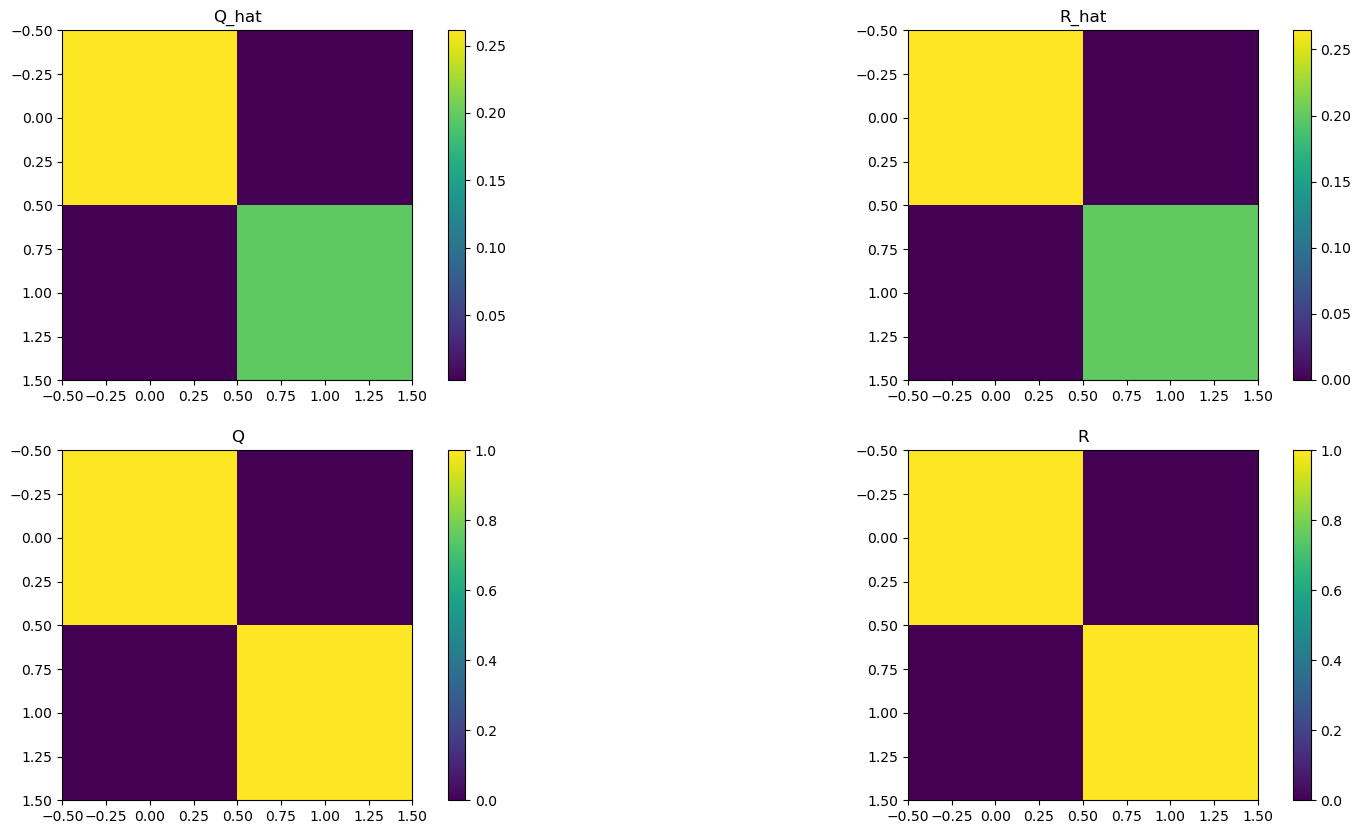

In [ ]:
# Reshape the theta back into the matrix.
Q_hat = np.zeros((env.dim_state, env.dim_state))
for (i, j) in state_indices:
    if i == j:
        Q_hat[i, j] = -theta[state_indices[(i, j)]]
    else:
        Q_hat[i, j] = -0.5 * theta[state_indices[(i, j)]]
        Q_hat[j, i] = Q_hat[i, j]

R_hat = np.zeros((env.dim_action, env.dim_action))
for (i, j) in control_indices:
    R_hat[i, j] = -theta[control_indices[(i, j)] + len(state_indices)]
    R_hat[j, i] = R_hat[i, j]

print("Q_hat: ", np.array_str(Q_hat), "\n Q: ", np.array_str(env.Q))
print("R_hat: ", np.array_str(R_hat), "\n R: ", np.array_str(env.R))

c_low = -1
c_high = 10

# visualize the Q_hat and R_hat as heatmaps
plt.subplots(2, 2, figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.imshow(Q_hat)
plt.colorbar()
plt.title("Q_hat")

plt.subplot(2, 2, 2)
plt.imshow(R_hat)
plt.colorbar()
plt.title("R_hat")

# Visualize the true Q and R as heatmaps
plt.subplot(2, 2, 3)
plt.imshow(env.Q)
plt.colorbar()
plt.title("Q")

plt.subplot(2, 2, 4)
plt.imshow(env.R)
#plt.clim(c_low, c_high)
plt.colorbar()
plt.title("R")



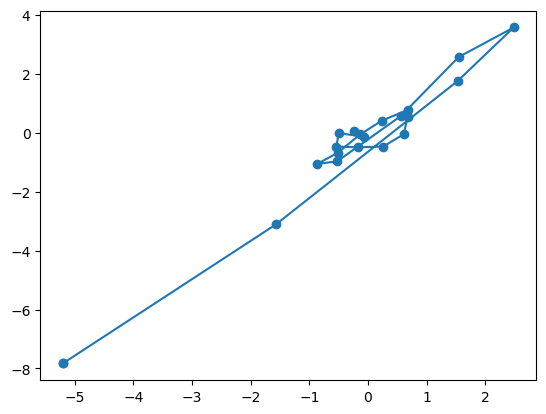

In [ ]:
xs = demonstrations[0][0][:, 0]
ys = demonstrations[0][0][:, 1]
plt.plot(xs, ys, 'o-', label="Expert")